In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
from src.datamodule import MSDataModule
from src.model import MSTransformer

[last_ckpt] = !ls -t1 ./lightning_logs/*/checkpoints/*.ckpt | head -n1
print(last_ckpt)

model = MSTransformer.load_from_checkpoint(last_ckpt)
dm = MSDataModule(**dict(model.hparams))

dm.setup()
model = model.cpu()
model.eval();

In [4]:
from tqdm import tqdm

embeddings = []
sequences = []
charges = []
ces = []
spectra = []

# fraction of detected peaks?
# fraction of b versus y?
# entropy?
# ...charge?

for i, batch in tqdm(enumerate(dm.val_dataloader())):
    z, z_mask = model.encoder(batch['x'],batch['x_mask'])
    z = (z * z_mask).sum(1) / z_mask.sum(1)
    z = z.detach().cpu().numpy()
    embeddings.append(z)
    
    y = batch['y'].cpu().numpy()
    y_mask = batch['y_mask'].cpu().numpy()
    
    spectra += [y_i[m_i.sum((1,2,3))>0] for y_i, m_i in zip(y, y_mask)]
    charges.append(batch['charge'].cpu().numpy())
    ces.append(batch['collision_energy'].cpu().numpy())
    sequences += batch['sequence']

embeddings = np.concatenate(embeddings,0)
charges = np.concatenate(charges,0)
ces = np.concatenate(ces,0)

embeddings = pd.DataFrame(embeddings)
# embeddings = embeddings.groupby(sequences).mean()
embeddings.shape

34it [03:47,  6.68s/it]


(34321, 256)

In [5]:
def polarity(sequence):
    is_basic = np.array([aa in 'RHK' for aa in sequence])
    polarity = (is_basic * np.arange(len(sequence))).sum() / np.arange(len(sequence)).sum()
    return polarity

import scanpy as sc
from scipy.stats import entropy

adata = sc.AnnData(embeddings)

adata.obs['sequence'] = sequences
adata.obs['length'] = adata.obs['sequence'].map(len)
adata.obs['first_aa'] = adata.obs['sequence'].str[0]
adata.obs['second_aa'] = adata.obs['sequence'].str[1]
adata.obs['last_aa'] = adata.obs['sequence'].str[-1]
adata.obs['num_basic'] = adata.obs['sequence'].map(lambda s: sum([c in 'RKH' for c in s])).astype(str)
adata.obs['polarity'] = adata.obs['sequence'].map(polarity)

/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [6]:
adata.obs['peak_entropy'] = [entropy(s.ravel())/s.shape[0] for s in spectra]
adata.obs['bond_entropy'] = [entropy(s.sum((1,2,3)).ravel())/s.shape[0] for s in spectra]
adata.obs['terminality'] = [s.sum((0,2,3))[-1]/s.sum() for s in spectra]

In [7]:
sc.tl.pca(adata, random_state=0)
sc.pp.neighbors(adata, random_state=0)
sc.tl.umap(adata, random_state=0)
sc.tl.leiden(adata, resolution=0.5)

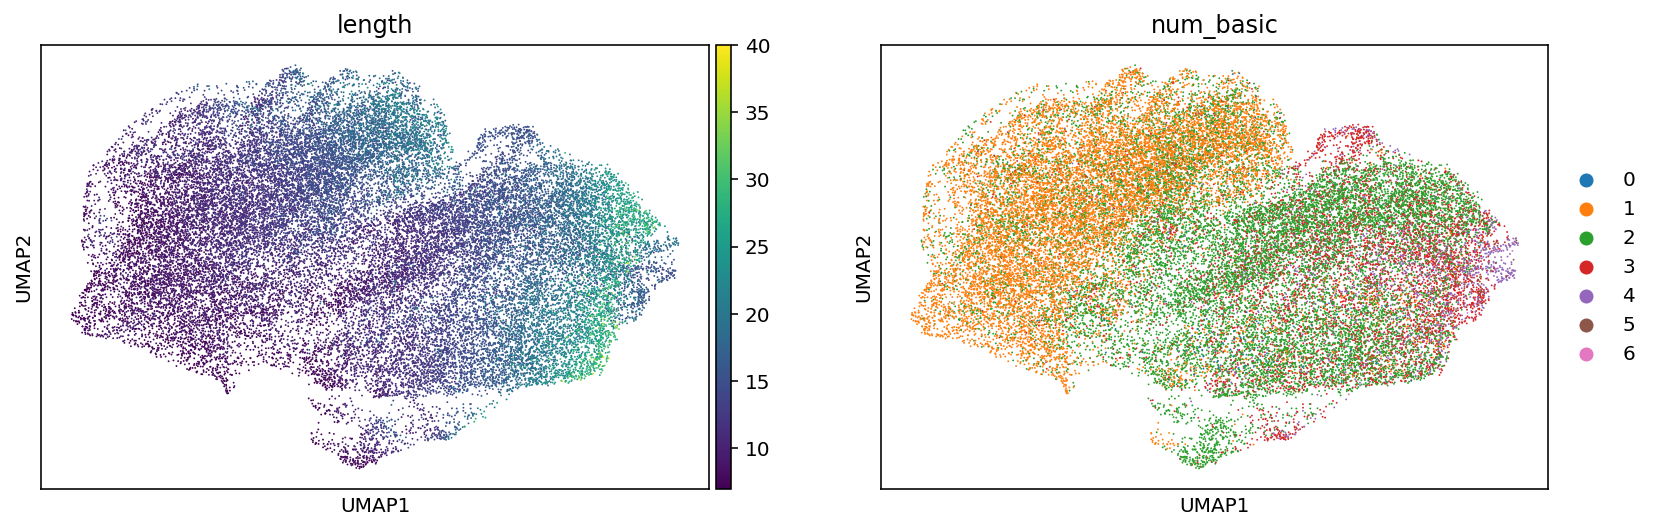

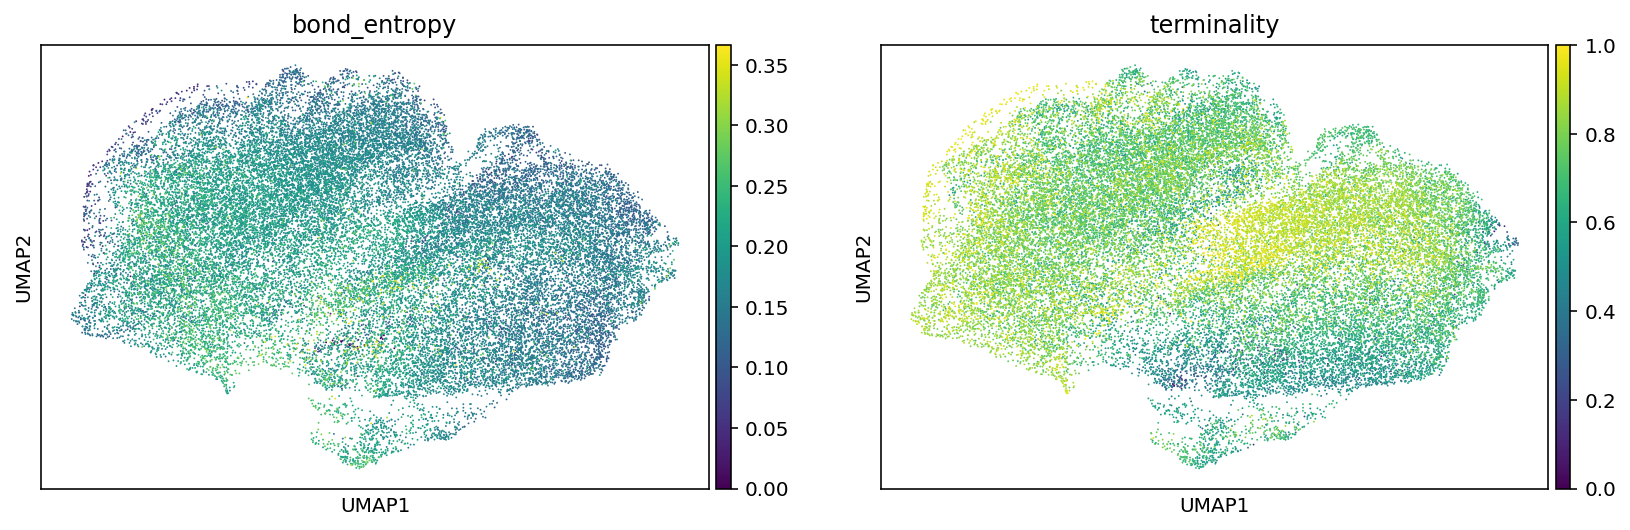

In [8]:
sc.pl.umap(adata,color=['length','num_basic'])
# sc.pl.umap(adata,color=['first_aa','last_aa'])
sc.pl.umap(adata,color=['bond_entropy','terminality'])

Do sequences within sequence-similarity clusters tend to be closer in fragment space? (IOW: "do distances in 'fragmentation space' have anything to do with edit distance?")

The more interesting question is the other way around. "Do sequences nearby in fragment space tend to be similar?"

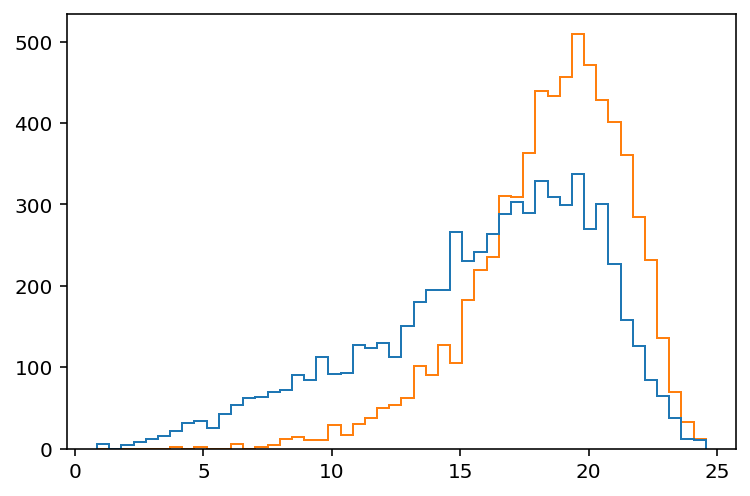

In [9]:
from src.cdhit import CDHIT
from sklearn.metrics import pairwise_distances

cdhit = CDHIT(
    threshold=0.9,
    word_length=5
)
clusters = np.array(cdhit.fit_predict(sequences))

X = embeddings.values.copy()

mean_dists = []
for i, c in enumerate(clusters):
    dists = pairwise_distances(X[clusters==c], X[[i]])
    dists = sorted(dists.ravel())[1:]
    if len(dists)==0:
        continue
    mean_dists.append(np.mean(dists))
    
npr.seed(0)
X = X[npr.permutation(X.shape[0])]

rand_dists = []
for i, c in enumerate(clusters):
    dists = pairwise_distances(X[clusters==c], X[[i]])
    dists = sorted(dists.ravel())[1:]
    if len(dists)==0:
        continue
    rand_dists.append(np.mean(dists))
    
plt.hist([mean_dists,rand_dists],bins=50,histtype='step');

If I rank all other sequences by distance to this one, what's the average rank of other sequences in the same CDHIT cluster? Is it any different than if clusters were assigned randomly?

34321it [03:31, 162.04it/s]


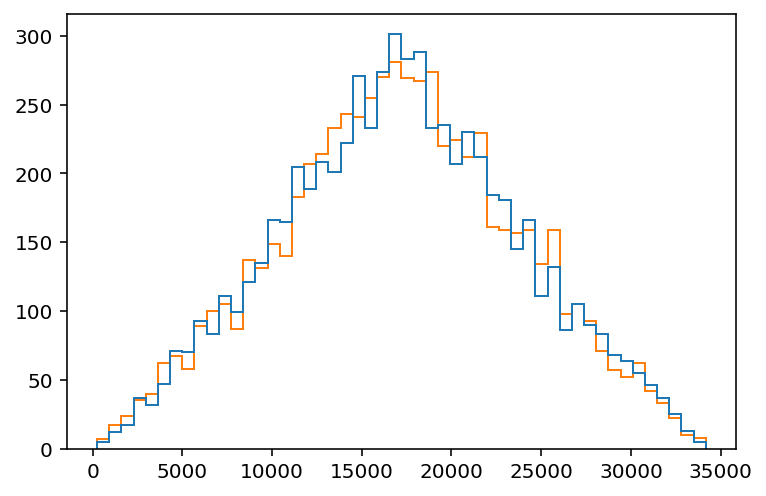

In [10]:
X = embeddings.values.copy()

npr.seed(0)

from collections import Counter
cluster_counts = Counter(clusters)

mean_ranks = []
rand_ranks = []
for i, c in tqdm(enumerate(clusters)):
    if cluster_counts[c]==1:
        continue
    dists = pairwise_distances(X, X[[i]]).ravel()
    dists[i] = np.inf
    ranks = np.argsort(dists)*1.
    ranks[-1] = np.nan
    mean_ranks.append(np.nanmean(ranks[clusters==c]))
    rand_ranks.append(np.nanmean(ranks[clusters[npr.permutation(len(clusters))]==c]))
    
plt.hist([mean_ranks,rand_ranks],bins=50,histtype='step');

<AxesSubplot:xlabel='leiden', ylabel='length'>

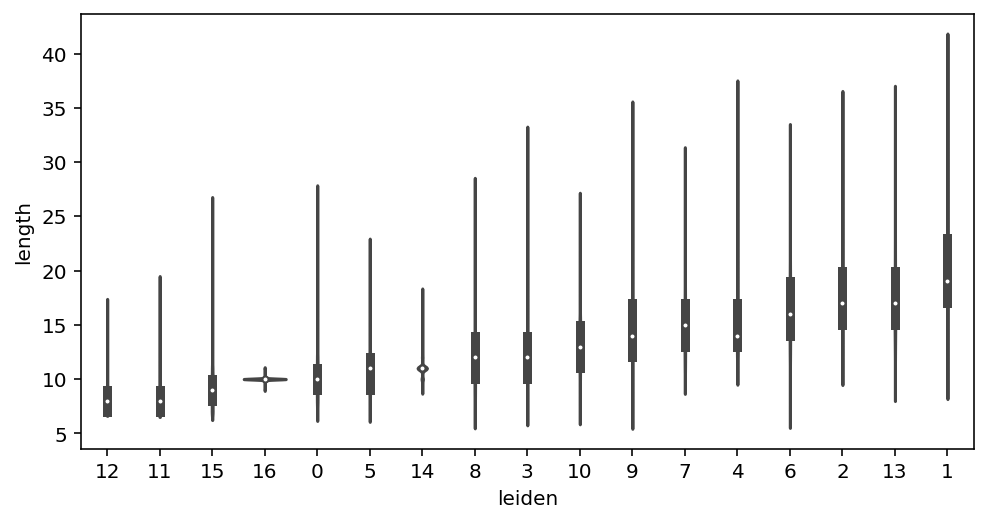

In [35]:
plt.figure(figsize=(8,4))
sns.violinplot(
    data=adata.obs,
    x='leiden',
    y='length',
    order=adata.obs.groupby('leiden')['length'].mean().sort_values().index
)

The clustering structure above is mainly length. **Suggests we could negative-sample on it...**

In [36]:
adata = adata[adata.obs['length']==11]

In [37]:
sc.tl.pca(adata, random_state=0)
sc.pp.neighbors(adata, random_state=0)
sc.tl.umap(adata, random_state=0)
sc.tl.leiden(adata,resolution=0.25, random_state=0)

adata.obs['pc1'] = adata.obsm['X_pca'][:,0]
adata.obs['pc2'] = adata.obsm['X_pca'][:,1]

adata

AnnData object with n_obs × n_vars = 3064 × 256
    obs: 'sequence', 'length', 'first_aa', 'second_aa', 'last_aa', 'num_basic', 'polarity', 'peak_entropy', 'bond_entropy', 'terminality', 'leiden', 'pc1', 'pc2'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'num_basic_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

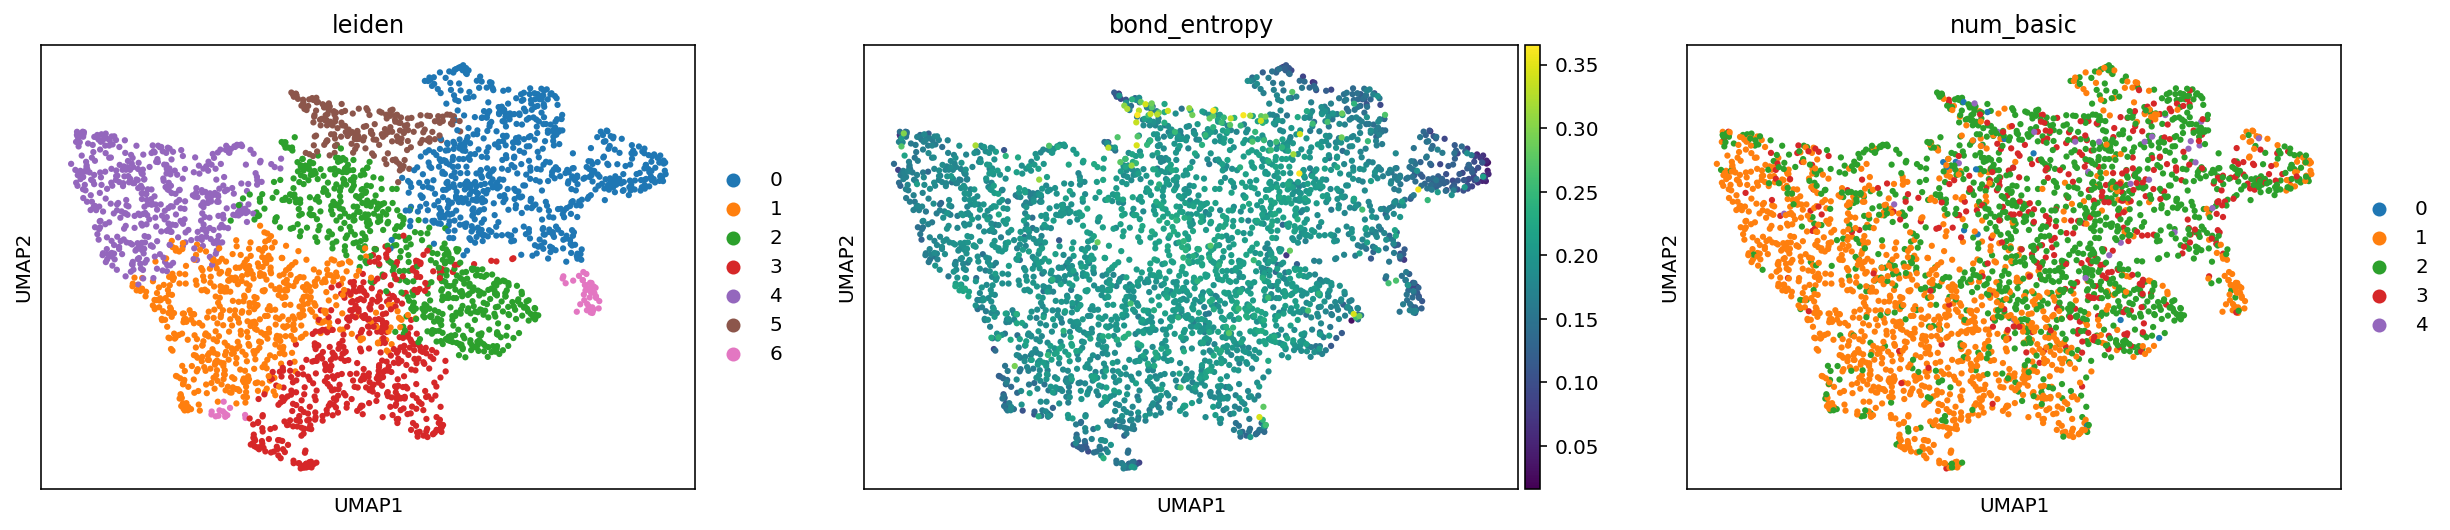

In [38]:
sc.pl.umap(adata,color=['leiden','bond_entropy','num_basic'])
# sc.pl.umap(adata,color=['first_aa','second_aa'])
# sc.pl.umap(adata,color=['pc1','pc2'])

Polarity still dominates.

/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


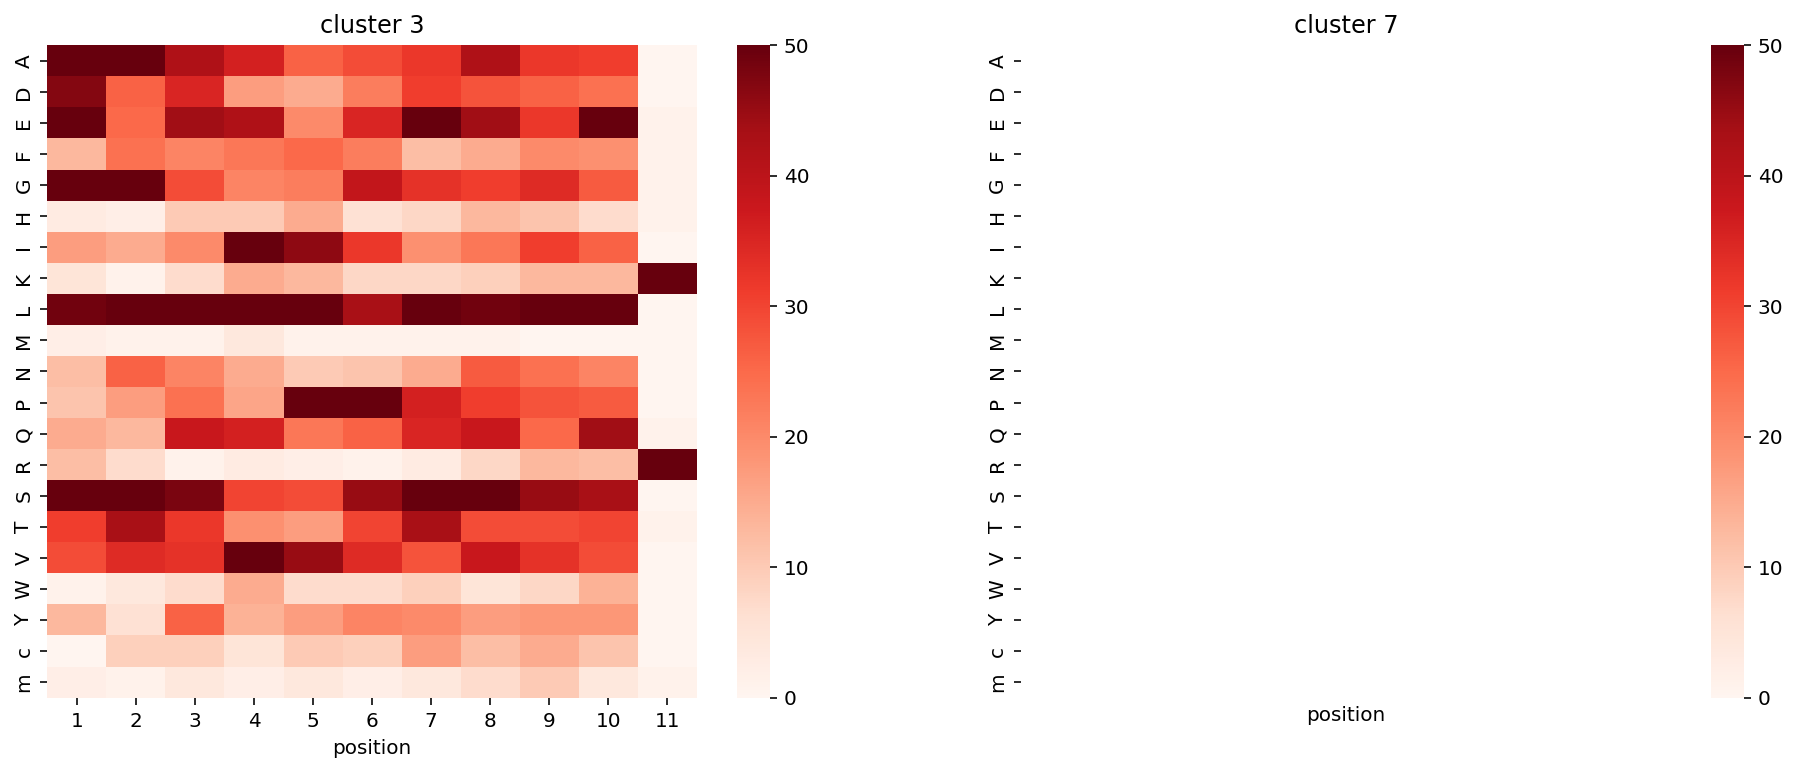

In [39]:
def plot_cluster(cluster, ax, vmax):
    df = pd.DataFrame(adata.obs.query(f'leiden=="{cluster}"')['sequence'].str.split('').tolist()).iloc[:,1:-1]
    df = df.apply(lambda c: c.value_counts())
    df = df.join(pd.Series({aa:0 for aa in model.residues[1:]},name='aa'),how='outer').drop(columns=['aa']).drop(index=['C','O'])
    df = df.fillna(0).astype(int)
    df.columns.name = 'position'
    plt.sca(ax)
    sns.heatmap(df,vmin=0,vmax=vmax,cmap='Reds')
    plt.title(f'cluster {cluster}')

fig,axs = plt.subplots(1,2,figsize=(16,6))
plot_cluster(3, axs[0], 50)
plot_cluster(7, axs[1], 50)
